In [64]:
# upload files from 1st to 29th from blr_march_actual
# upload the simulated files from 25th to 29th march

# Data Prepration

In [44]:
import pandas as pd

# Define file paths
dates = ["2025-03-01", "2025-03-02", "2025-03-03", "2025-03-04", "2025-03-05",
         "2025-03-06", "2025-03-07", "2025-03-08", "2025-03-09", "2025-03-10",
         "2025-03-11", "2025-03-12", "2025-03-13", "2025-03-14", "2025-03-15",
         "2025-03-16", "2025-03-17", "2025-03-18", "2025-03-19", "2025-03-20",
         "2025-03-21", "2025-03-22", "2025-03-23", "2025-03-24", "2025-03-25_sim",
         "2025-03-26_sim", "2025-03-27_sim", "2025-03-28_sim", "2025-03-29_sim"]
file_paths = [f"/content/{date}.csv" for date in dates]

# Load and concatenate all files
df_list = [pd.read_csv(file) for file in file_paths]
combined_df = pd.concat(df_list, ignore_index=True)

# Save the combined data
combined_df.to_csv("/content/combined_data.csv", index=False)

print("Combined file saved as 'combined_data.csv'.")


Combined file saved as 'combined_data.csv'.


# Feature Enginnering

In [45]:
import numpy as np
import pandas as pd

# Load the data
df = pd.read_csv('/content/combined_data.csv', parse_dates=['date_time'])

# Extract time-based features
df['hour'] = df['date_time'].dt.hour
df['day_of_week'] = df['date_time'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Create lag features (up to 3 lags for simplicity)
for i in range(1, 4):
    df[f'lag_{i}'] = df['load'].shift(i)

# Create rolling window features (3-hour window)
df['rolling_mean_3'] = df['load'].rolling(window=3).mean()
df['rolling_std_3'] = df['load'].rolling(window=3).std()

# Add day progress and cyclic time features
df['day_progress'] = df['hour'] / 24
df['day_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['day_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# Drop rows with NaN values caused by lagging and rolling
df = df.dropna()

# Save the feature engineered data
df.to_csv('/content/feature_engineered_data.csv', index=False)
print("Feature engineering completed and saved as 'feature_engineered_data.csv'.")


Feature engineering completed and saved as 'feature_engineered_data.csv'.


# Scaling


In [46]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib

# Load the feature-engineered data
df = pd.read_csv('/content/feature_engineered_data.csv')

# Separate features and target
X = df.drop(columns=['load', 'date_time'])  # Drop timestamp if it exists
y = df['load'].values.reshape(-1, 1)

# Initialize Min-Max Scalers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Scale the features and target
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Save the scalers for future use
joblib.dump(scaler_X, '/content/scaler_X.pkl')
joblib.dump(scaler_y, '/content/scaler_y.pkl')

# Convert to DataFrame for saving
scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
scaled_df['load'] = y_scaled

# Save the scaled data
scaled_df.to_csv('/content/scaled_data.csv', index=False)
print("Scaling completed. Data saved as 'scaled_data.csv'. Scalers saved.")


Scaling completed. Data saved as 'scaled_data.csv'. Scalers saved.


In [47]:
import pandas as pd

# Load the scaled data and the original feature-engineered data
scaled_df = pd.read_csv('/content/scaled_data.csv')
original_df = pd.read_csv('/content/feature_engineered_data.csv', parse_dates=['date_time'])

# Ensure both datasets are aligned
assert len(scaled_df) == len(original_df), "Mismatch in data lengths!"

# Extract timestamps for reference
timestamps = original_df['date_time']

# Define masks for new train and test ranges
train_mask = (timestamps.dt.date >= pd.to_datetime('2025-03-01').date()) & \
             (timestamps.dt.date <= pd.to_datetime('2025-03-24').date())
test_mask = (timestamps.dt.date >= pd.to_datetime('2025-03-25').date()) & \
            (timestamps.dt.date <= pd.to_datetime('2025-03-29').date())

# Split based on date range
X_train = scaled_df.loc[train_mask].drop(columns=['load'])
y_train = scaled_df.loc[train_mask, 'load']
X_test = scaled_df.loc[test_mask].drop(columns=['load'])
y_test = scaled_df.loc[test_mask, 'load']
test_timestamps = timestamps.loc[test_mask]

# Save data to CSV
X_train.to_csv('/content/X_train.csv', index=False)
X_test.to_csv('/content/X_test.csv', index=False)
y_train.to_csv('/content/y_train.csv', index=False)
y_test.to_csv('/content/y_test.csv', index=False)
test_timestamps.to_csv('/content/test_timestamps.csv', index=False)

print("Train-test split completed and saved.")
print("Timestamps for test data saved as 'test_timestamps.csv' for reference.")


Train-test split completed and saved.
Timestamps for test data saved as 'test_timestamps.csv' for reference.


# Re-shaping

In [48]:
import numpy as np
import pandas as pd

def reshape_data(X, y, n_lags=24):
    """
    Reshape the data into 3D format for RNN (samples, time_steps, features).
    """
    X_reshaped, y_reshaped = [], []
    for i in range(n_lags, len(X)):
        X_reshaped.append(X.iloc[i-n_lags:i].values)
        y_reshaped.append(y.iloc[i])
    return np.array(X_reshaped), np.array(y_reshaped)


In [49]:
# Load the split data
X_train = pd.read_csv('/content/X_train.csv')
X_test = pd.read_csv('/content/X_test.csv')
y_train = pd.read_csv('/content/y_train.csv')
y_test = pd.read_csv('/content/y_test.csv')

# Reshape into 3D for RNN
X_train_reshaped, y_train_reshaped = reshape_data(X_train, y_train)
X_test_reshaped, y_test_reshaped = reshape_data(X_test, y_test)

# Save the reshaped data
np.save('/content/X_train_reshaped.npy', X_train_reshaped)
np.save('/content/y_train_reshaped.npy', y_train_reshaped)
np.save('/content/X_test_reshaped.npy', X_test_reshaped)
np.save('/content/y_test_reshaped.npy', y_test_reshaped)

print("Data reshaped to 3D and saved as .npy files.")


Data reshaped to 3D and saved as .npy files.


# Model Architecture

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Build the RNN model with input shape (24, 11)
model = Sequential()

# First RNN Layer
model.add(SimpleRNN(64, activation='tanh', return_sequences=True, input_shape=(24, 11)))

# Second RNN Layer
model.add(SimpleRNN(32, activation='tanh', return_sequences=True))

# Third RNN Layer
model.add(SimpleRNN(16, activation='tanh', return_sequences=False))

# Dense Layer
model.add(Dense(32, activation='relu'))

# Output Layer
model.add(Dense(1))

# Compile the Model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("Model recompiled with input shape (24, 11).")


Model recompiled with input shape (24, 11).


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Model training

In [51]:
print("X_train shape:",X_train_reshaped.shape)
print("X_test shape:",X_test_reshaped.shape)
print("y_train shape:",y_train_reshaped.shape)
print("y_test shape:",y_test_reshaped.shape)


X_train shape: (2277, 24, 11)
X_test shape: (456, 24, 11)
y_train shape: (2277, 1)
y_test shape: (456, 1)


In [52]:
import numpy as np

X_train = np.load('/content/X_train_reshaped.npy')
y_train = np.load('/content/y_train_reshaped.npy')

X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)


print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_train dtype:", X_train.dtype)
print("y_train dtype:", y_train.dtype)

X_train shape: (2277, 24, 11)
y_train shape: (2277, 1)
X_train dtype: float32
y_train dtype: float32


In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Define the RNN Model
model = Sequential([
    SimpleRNN(50, input_shape=(24, 11), return_sequences=False),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [54]:
import os
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping

# Load reshaped data
X_train = np.load('/content/X_train_reshaped.npy')
y_train = np.load('/content/y_train_reshaped.npy')

# Remove any existing model
model_path = '/content/rnn_model.h5'
if os.path.exists(model_path):
    os.remove(model_path)
    print("Existing model removed.")
else:
    print("No existing model found. Proceeding with training.")

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Save the new model
model.save(model_path)
print("Model training completed and saved as 'rnn_model.h5'.")


Existing model removed.
Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.1892 - val_loss: 0.0050
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0040 - val_loss: 0.0046
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0034 - val_loss: 0.0039
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0025 - val_loss: 0.0033
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0024 - val_loss: 0.0029
Epoch 9/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 10/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0022 - val_loss: 0.0036
Epoch 11/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 12/100
57/57 ━━━━━━━━━━━━━━━━

Model training completed and saved as 'rnn_model.h5'.


# Prediction and saving


In [55]:
print("X_test shape:", X_test.shape)
print("Expected Output Shape:", model.output_shape)


X_test shape: (480, 11)
Expected Output Shape: (None, 1)


In [56]:
from tensorflow.keras.models import load_model
import tensorflow.keras.losses

# Load model with correct loss function
model_path = '/content/rnn_model.h5'
model = load_model(model_path, custom_objects={'mse': 'mean_squared_error'})
print("Model loaded successfully.")

scaler_y = joblib.load("/content/scaler_y.pkl")  # Load saved scaler

X_test = np.load('/content/X_test_reshaped.npy')

# Perform prediction
y_pred_scaled = model.predict(X_test)
print("Prediction completed.")

# Inverse scaling using the same scaler
y_pred = scaler_y.inverse_transform(y_pred_scaled)

print(y_pred)
print("Number of predicted values:", len(y_pred))


Model loaded successfully.
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Prediction completed.
[[12431.272 ]
 [12678.773 ]
 [13221.276 ]
 [13946.313 ]
 [14159.975 ]
 [14565.18  ]
 [14852.907 ]
 [15011.677 ]
 [14958.432 ]
 [15017.795 ]
 [15303.81  ]
 [15746.066 ]
 [15923.81  ]
 [16244.107 ]
 [16584.322 ]
 [16607.705 ]
 [16386.312 ]
 [16439.807 ]
 [16436.832 ]
 [16252.391 ]
 [16007.004 ]
 [16286.958 ]
 [16367.5205]
 [16207.245 ]
 [15985.707 ]
 [16064.881 ]
 [16164.174 ]
 [16157.691 ]
 [16097.793 ]
 [16090.383 ]
 [16104.319 ]
 [16145.626 ]
 [15919.611 ]
 [15861.056 ]
 [16241.775 ]
 [16371.686 ]
 [16155.783 ]
 [16138.33  ]
 [16292.207 ]
 [16114.762 ]
 [15663.041 ]
 [15330.225 ]
 [15171.585 ]
 [14827.849 ]
 [14130.427 ]
 [13840.329 ]
 [13776.648 ]
 [13472.419 ]
 [12517.592 ]
 [11383.06  ]
 [11719.713 ]
 [12105.742 ]
 [11993.717 ]
 [11911.88  ]
 [11748.3955]
 [11827.206 ]
 [11530.056 ]
 [11477.48  ]
 [11427.823 ]
 [11075.002 ]
 [11545.948 ]
 [11792.796 ]
 [11662.638 ]
 [11448.73  ]
 [11914.919 ]
 

In [57]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

# Load trained model
model_path = "/content/rnn_model.h5"
model = load_model(model_path, custom_objects={"mse": "mean_squared_error"})
print("Model loaded successfully.")

# Load the same scaler used during training
scaler_y = joblib.load("/content/scaler_y.pkl")

# Load reshaped test data
X_test = np.load("/content/X_test_reshaped.npy")

# Perform prediction
y_pred_scaled = model.predict(X_test)
print("Prediction completed.")

# Inverse scaling
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Load timestamps
timestamps_df = pd.read_csv("/content/test_timestamps.csv")

# Truncate the first 24 timestamps to match prediction length (keep last 72 rows)
timestamps_df = timestamps_df.iloc[24:].reset_index(drop=True)

# Create a DataFrame with timestamps and predictions
final_df = pd.DataFrame({"date_time": timestamps_df["date_time"], "load": y_pred.flatten()})

# Save to CSV
output_path = "/content/final_predictions.csv"
final_df.to_csv(output_path, index=False)

print(f"Predictions saved successfully at {output_path}")


Model loaded successfully.
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Prediction completed.
Predictions saved successfully at /content/final_predictions.csv


# merging prediction files with simulated files


In [58]:
import pandas as pd

# Load WMA and RNN prediction files
wma_df = pd.read_csv("/content/2025-03-25_sim.csv")
rnn_df = pd.read_csv("/content/final_predictions.csv")

# Extract the first 24 blocks from WMA
wma_first_24 = wma_df.iloc[:24]

# Concatenate WMA first 24 rows with RNN predictions
final_df = pd.concat([wma_first_24, rnn_df], ignore_index=True)

# Save the updated final predictions
final_df.to_csv("/content/final_predictions.csv", index=False)

print("Successfully merged WMA first 24 blocks with simulated predictions. File saved!")


Successfully merged WMA first 24 blocks with simulated predictions. File saved!


# Saving prediction date_wise


In [59]:
import pandas as pd
import os

# Load predictions
pred_df = pd.read_csv('/content/final_predictions.csv', parse_dates=['date_time'])

# Ensure the predictions folder exists
os.makedirs('/content/predictions', exist_ok=True)

# Loop over dates from 25 to 29 March
for day in range(25, 30):
    date_str = f'2025-03-{day:02d}'
    daily_df = pred_df[pred_df['date_time'].dt.date == pd.to_datetime(date_str).date()]

    # Save to individual CSV
    output_path = f'/content/predictions/{date_str}_predicted.csv'
    daily_df.to_csv(output_path, index=False)

print("✅ Predictions split and saved by date in '/content/predictions/' folder.")


✅ Predictions split and saved by date in '/content/predictions/' folder.


# Visualization and metrics

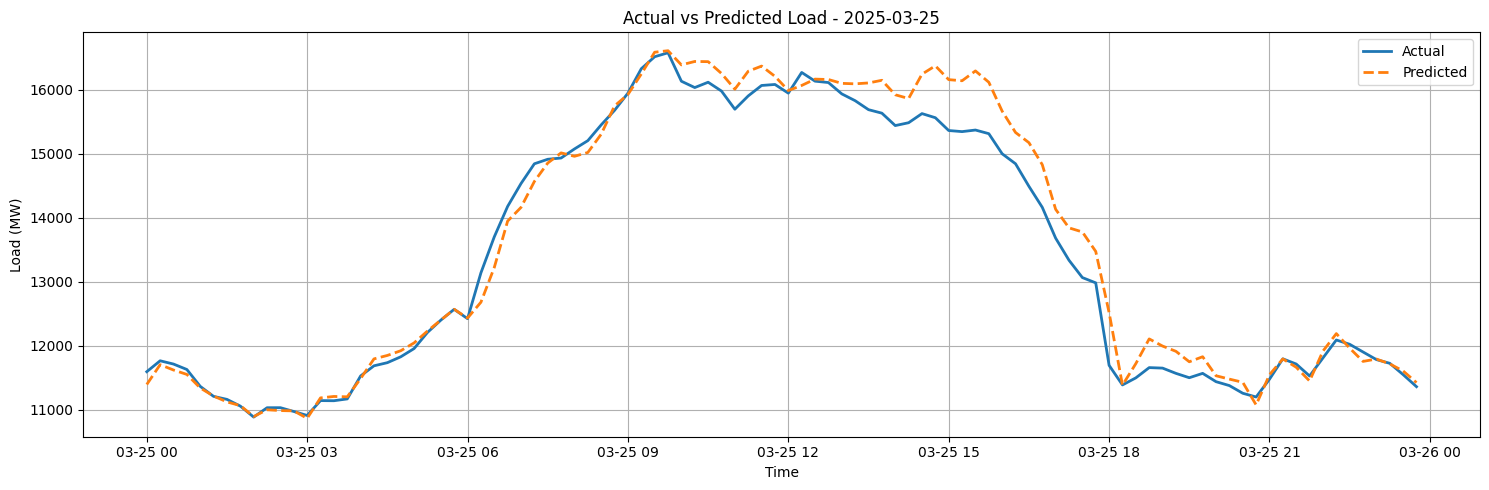

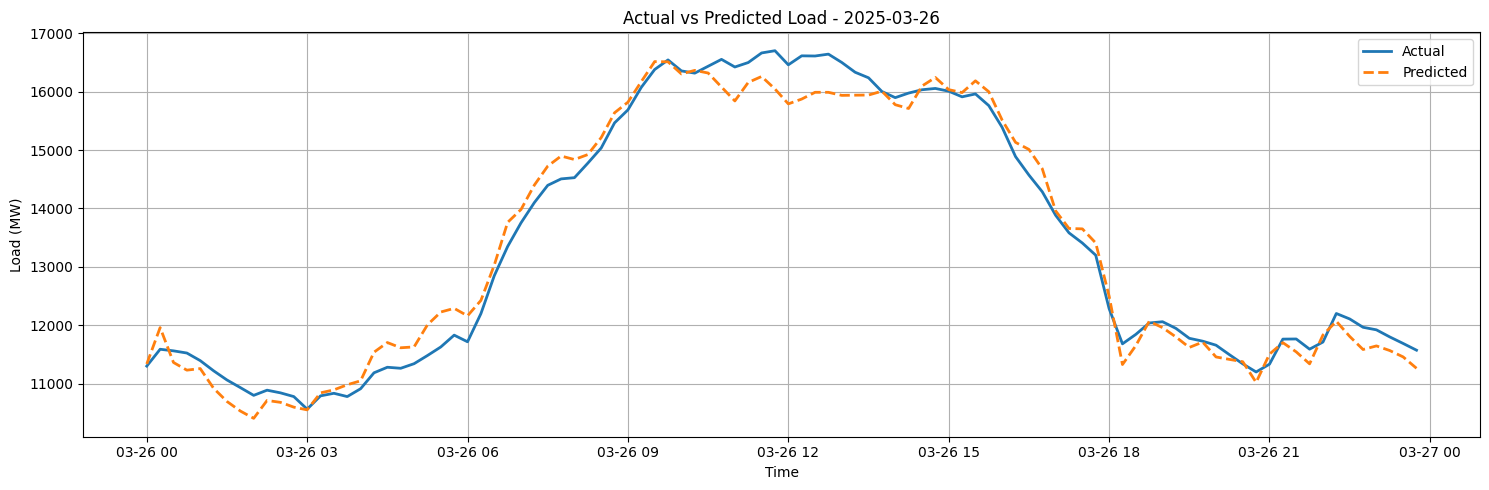

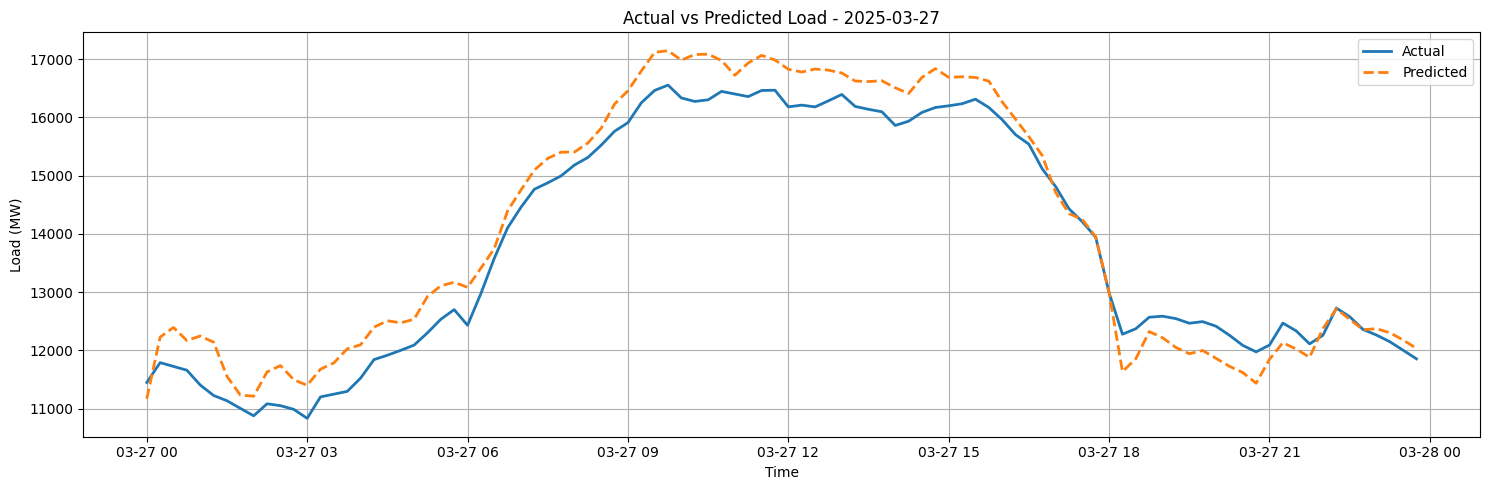

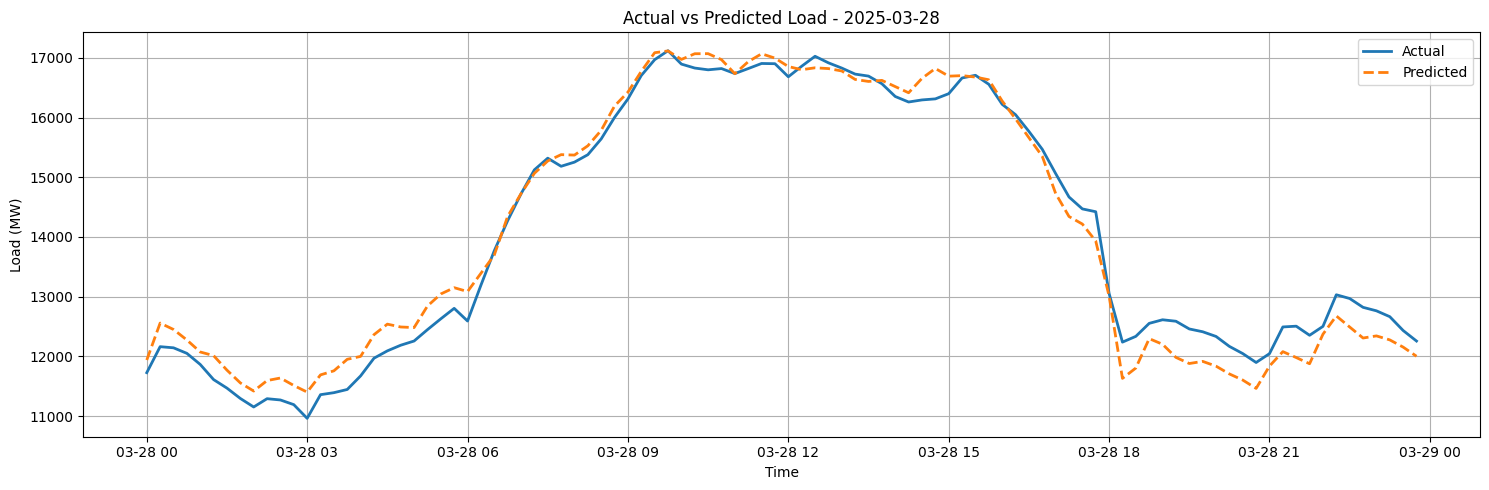

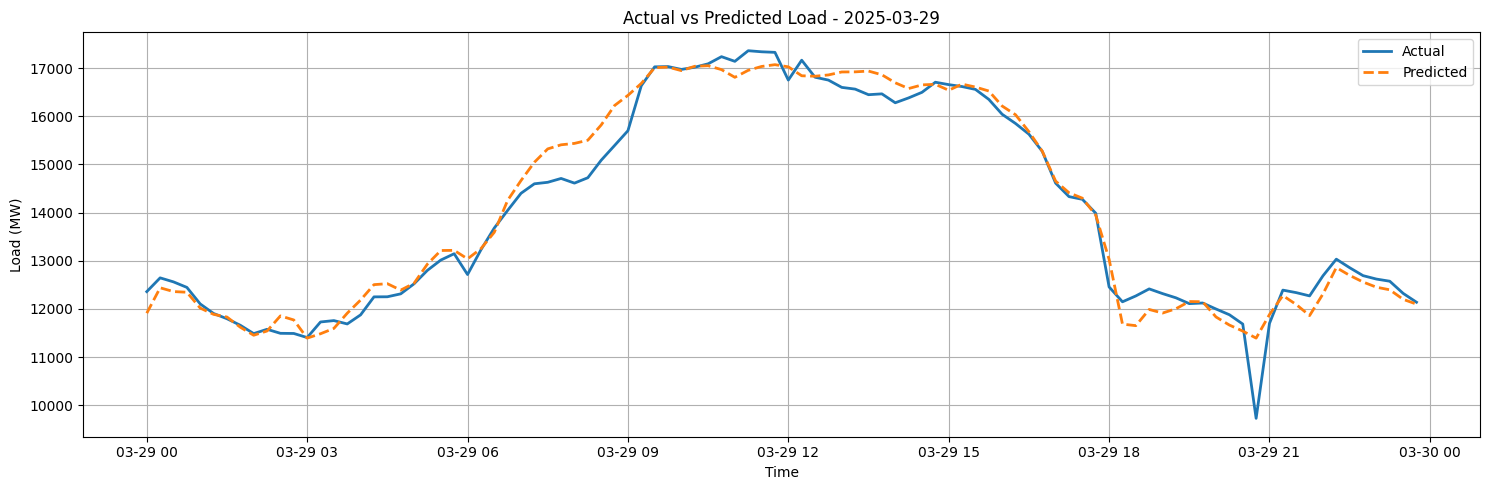

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

# Dates to loop through
dates = [f"2025-03-{day:02d}" for day in range(25, 30)]

# Loop through each date
for date in dates:
    actual_path = f"/content/{date}.csv"
    predicted_path = f"/content/predictions/{date}_predicted.csv"

    # Load actual and predicted data
    actual_df = pd.read_csv(actual_path, parse_dates=['date_time'])
    predicted_df = pd.read_csv(predicted_path, parse_dates=['date_time'])

    # Extract load values
    actual = actual_df['load'].values
    predicted = predicted_df['load'].values

    # Plot actual vs predicted
    plt.figure(figsize=(15, 5))
    time_labels = pd.to_datetime(actual_df['date_time'])
    plt.plot(time_labels, actual, label='Actual', linewidth=2)
    plt.plot(time_labels, predicted, label='Predicted', linestyle='--', linewidth=2)
    plt.title(f"Actual vs Predicted Load - {date}")
    plt.xlabel("Time")
    plt.ylabel("Load (MW)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


📊 Forecast Metrics:

Date                MAE       RMSE   MAPE (%)
----------------------------------------------
2025-03-25       231.44     333.33       1.65
2025-03-26       252.13     304.24       1.89
2025-03-27       428.99     474.90       3.17
2025-03-28       262.78     310.05       2.03
2025-03-29       245.23     351.29       1.81


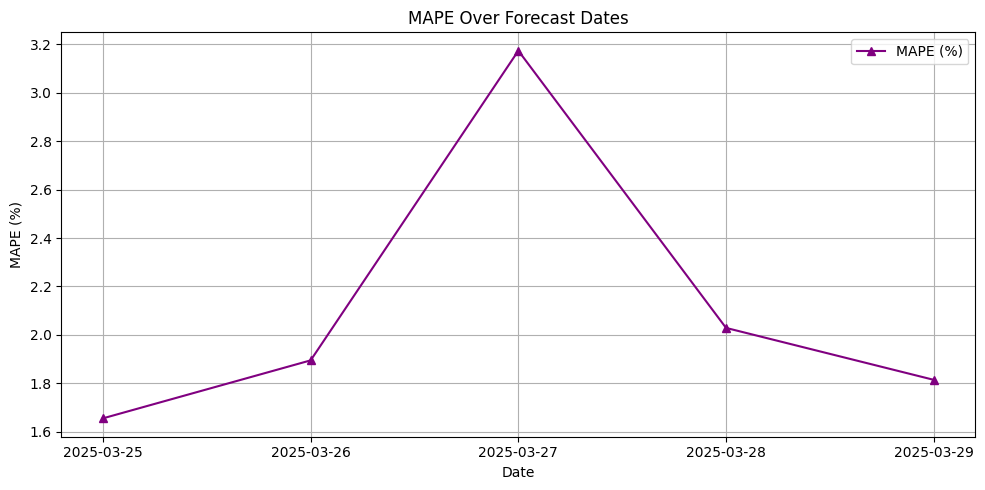

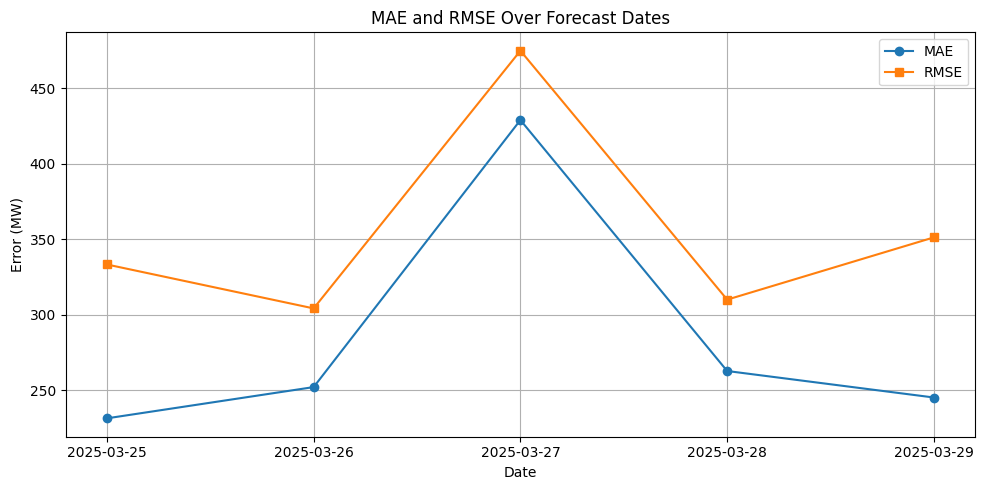

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Helper function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Initialize lists for storing metrics
dates = [f"2025-03-{day:02d}" for day in range(25, 30)]
maes, rmses, mapes = [], [], []

# Calculate metrics for each date
print("📊 Forecast Metrics:\n")
print("{:<12} {:>10} {:>10} {:>10}".format("Date", "MAE", "RMSE", "MAPE (%)"))
print("-" * 46)

for date in dates:
    actual_path = f"/content/{date}.csv"
    predicted_path = f"/content/predictions/{date}_predicted.csv"

    actual_df = pd.read_csv(actual_path)
    predicted_df = pd.read_csv(predicted_path)

    actual = actual_df['load'].values
    predicted = predicted_df['load'].values

    # Metrics
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(actual, predicted)

    maes.append(mae)
    rmses.append(rmse)
    mapes.append(mape)

    print(f"{date:<12} {mae:10.2f} {rmse:10.2f} {mape:10.2f}")

# Plot MAPE
plt.figure(figsize=(10, 5))
plt.plot(dates, mapes, marker='^', color='purple', label='MAPE (%)')
plt.title("MAPE Over Forecast Dates")
plt.xlabel("Date")
plt.ylabel("MAPE (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot MAE and RMSE
plt.figure(figsize=(10, 5))
plt.plot(dates, maes, marker='o', label='MAE')
plt.plot(dates, rmses, marker='s', label='RMSE')
plt.title("MAE and RMSE Over Forecast Dates")
plt.xlabel("Date")
plt.ylabel("Error (MW)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
